# MODELING

## PROBLEM DEFINITION AND GOALS

**We aim to model, predict, and simulate foreign aid dynamics for Kenya.**  

### CORE MODELING OBJECTIVES

1. **Aid Flow Stability And Volatility Analysis**  
   - Goal: Identify which sectors, agencies, and partners are most stable, volatile, or dominant in aid delivery.  
   - Approach:  
     - Compute volatility metrics (rolling std, coefficient of variation).  
     - Classify entities using unsupervised clustering or ranking.  
     - Highlight dominant vs. emerging actors.

2. **Predictive And Scenario Forecasting**  
   - Goal: Predict future funding flows or simulate policy shocks (e.g., “25% cut in USAID funding”).  
   - Approach: 
     - Use regression models (XGBoost, Random Forest, Prophet) on aid totals.  
     - Simulate counterfactual scenarios by adjusting model inputs.

3. **Temporal Forecasting And Shock Simulation**  
   - Goal: Model aid trends across fiscal years and assess resilience to fiscal shocks.  
   - Approach:  
     - Time series forecasting (Prophet, ARIMA, LSTM).  
     - Introduce synthetic shocks to test system response.

4. **Sectoral Dependency Clustering**  
   - Goal: Cluster sectors by their dependency on foreign aid.  
   - Approach:  
     - Use KMeans, DBSCAN, or hierarchical clustering.  
     - Base features on aid ratios and concentration metrics.

## DATA AUDIT

### STRONG COLUMNS
Provide robust quantitative and categorical anchors:
- Temporal: fiscal_year, transaction_date, year, quarter
- Categorical Context: country_name, us_sector_name, us_category_name
- Management Context: managing_subagency_or_bureau_name, funded_and_managed_by, dominant_sector_per_agency
- Monetary & Variability Indicators:  
  current_dollar_amount, constant_dollar_amount, total_aid_fiscal,  
  aid_volatility, rolling_mean_3yr, rolling_std_3yr, aid_concentration_index,  
  top3_agency_share, sector_to_total_ratio, agency_to_total_ratio,  
  aid_per_partner, relative_aid_share, aid_std_fiscal,  
  mean_aid_per_transaction_fiscal

### COLUMNS THAT NEED ATTENTION
- objective, transaction_type_name -> will need grouping or encoding.  
- transaction_lag, transaction_lead -> align correctly with fiscal years.    

### COLUMNS TO DROP
- transaction_date -> replace with derived temporal features.  
- country_name -> constant for Kenya, can be dropped.  
- Columns ending in _interaction -> use dimensionality reduction (PCA) or selective inclusion.

## WORKFLOW

### DATA PREPARATION
1. Handle missingness with appropriate imputations.  
2. Normalize skewed monetary variables (we will use log1p).  
3. Encode categorical variables using **target encoding** or **frequency encoding**.  
4. Aggregate aid data by **year**, **sector**, or **agency** depending on the model goal.  
5. Split data chronologically (e.g train up to 2019, test from 2020 onward).

### FEATURE ENGINEERING CONSIDERATIONS
- Rolling averages: rolling_mean_3yr, rolling_std_3yr, sector_growth_rate, agency_growth_rate
- Concentration & diversity: aid_concentration_index, aid_diversity_index
- Ratios: sector_to_total_ratio, agency_to_total_ratio
- Interaction terms: agency_sector_interaction, partner_agency_interaction

### TARGET PICKING

| Objective | Problem Type | Model Candidates | Key Targets |
|------------|---------------|------------------|--------------|
| **Stability & Volatility** | Unsupervised / Ranking | KMeans, Isolation Forest, PCA, TS Clustering | aid_volatility, aid_concentration_index |
| **Predictive Forecasting** | Supervised Regression | XGBoost, LightGBM, Prophet | total_aid_fiscal, constant_dollar_amount |
| **Temporal Forecasting** | Time Series | Prophet, ARIMA, LSTM | total_aid_fiscal, sector_to_total_ratio |
| **Sector Dependency** | Clustering | KMeans, Spectral, DBSCAN | sector_to_total_ratio, aid_per_partner, aid_concentration_index |

### EVALUATION METRICS
- **Regression Models:** RMSE, MAE, MAPE, R²  
- **Forecasting Models:** MAPE, RMSE, Directional Accuracy  
- **Clustering Models:** Silhouette Score, Calinski-Harabasz Index  
- **Volatility Analysis:** Rolling std comparison, stability ranking

### SCENARIO SIMULATION
Run post-model scenario experiments:
- Introduce a **shock factor**, e.g., USAID_cut = -0.25  
- Recompute predicted totals and compare to baseline.  
- Measure cascading impacts by sector (sector_to_total_ratio shifts).  
- Visualize using waterfall charts or delta bar plots.

### VISUALS
- **Time Series:** Aid trends per sector/agency.  
- **Heatmaps:** Volatility or concentration over time.  
- **Cluster Maps:** Sector dependency visualization.  
- **Scenario Dashboards:** Policy or funding cut simulations.

In [ ]:
# ------- [Import all relevant libraries] -------

# General Utilities
import warnings
warnings.filterwarnings('ignore')

import numpy as np                          # Numerical computing
import pandas as pd                         # Data manipulation and analysis
import datetime as dt                       # Date/time operations
import re                                   # String manipulation
from collections import Counter             # Frequency counting
import logging

# Visualization
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
import seaborn as sns

# Feature Engineering & Preprocessing
from sklearn.preprocessing import (
    LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
)
from sklearn.model_selection import (
    train_test_split, TimeSeriesSplit, GridSearchCV, StratifiedKFold
)
from sklearn.decomposition import PCA, TruncatedSVD

# Machine Learning Models
# ======================

## Supervised Learning (Regression/Prediction)
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

## Unsupervised Learning (Volatility and Dependency Clustering)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score

## Time Series & Forecasting
from statsmodels.tsa.arima.model import ARIMA
# !pip install prophet
from prophet import Prophet

# Evaluation Metrics
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    silhouette_score, calinski_harabasz_score
)

# # Imbalanced Data Handling
# from imblearn.over_sampling import SMOTE

# Model Interpretation & Explainability
# !pip install eli5
from lime import lime_tabular

# Pipelines
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

# Display Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
from IPython.display import display

In [9]:
# Load modeling dataset
df = pd.read_csv("../Clean Data/clean_data.csv")

# Drop country_name
df.drop(columns=['country_name'], inplace=True)

In [10]:
df.columns

Index(['managing_subagency_or_bureau_name', 'us_category_name',
       'us_sector_name', 'objective', 'transaction_type_name', 'fiscal_year',
       'transaction_date', 'current_dollar_amount', 'constant_dollar_amount',
       'transaction_year', 'transaction_month', 'transaction_quarter',
       'is_end_of_fiscal_year', 'days_since_start_of_year',
       'is_holiday_quarter', 'aid_volatility', 'rolling_mean_3yr',
       'rolling_std_3yr', 'total_aid_fiscal', 'transaction_count_fiscal',
       'mean_aid_per_transaction_fiscal', 'aid_std_fiscal', 'total_sector_aid',
       'avg_sector_aid', 'sector_transaction_count', 'total_agency_aid',
       'avg_agency_aid', 'agency_transaction_count', 'total_partner_aid',
       'partner_transaction_count', 'sector_to_total_ratio',
       'agency_to_total_ratio', 'transaction_lag', 'transaction_lead',
       'sector_growth_rate', 'agency_growth_rate', 'partner_growth_rate',
       'agency_count_fiscal', 'aid_concentration_index', 'top3_agency_share

In [28]:
df.isna().sum()

managing_subagency_or_bureau_name        0
us_category_name                         0
us_sector_name                           0
objective                                0
transaction_type_name                    0
fiscal_year                              0
transaction_date                         0
current_dollar_amount                    0
constant_dollar_amount                   0
transaction_year                         0
transaction_month                        0
transaction_quarter                      0
is_end_of_fiscal_year                    0
days_since_start_of_year                 0
is_holiday_quarter                       0
aid_volatility                           0
rolling_mean_3yr                         0
rolling_std_3yr                          0
total_aid_fiscal                         0
transaction_count_fiscal                 0
mean_aid_per_transaction_fiscal          0
aid_std_fiscal                           0
total_sector_aid                         0
avg_sector_

2025-10-31 12:29:42,318 INFO 81 numeric candidate features selected
2025-10-31 12:29:42,321 INFO Train years: [np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022)]; Val: [2023]; Test: [2025, 2024]
2025-10-31 12:29:42,322 INFO Shapes — train: (345, 85), val: (35, 85), test: (58, 85)


[0]	train-auc:0.99149	eval-auc:1.00000
[49]	train-auc:0.99963	eval-auc:1.00000


2025-10-31 12:29:42,636 INFO Best threshold: 0.810 (F1=1.000)



=== Test Metrics ===
AUC: 1.0000
Accuracy: 0.9655
Precision: 0.9474
Recall: 1.0000
F1: 0.9730

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.91      0.95        22
           1       0.95      1.00      0.97        36

    accuracy                           0.97        58
   macro avg       0.97      0.95      0.96        58
weighted avg       0.97      0.97      0.97        58



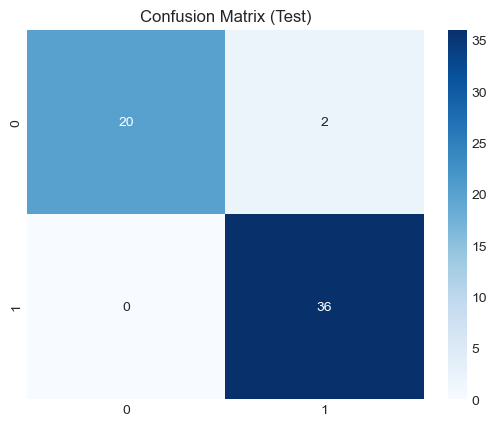

PR-AUC: 1.0


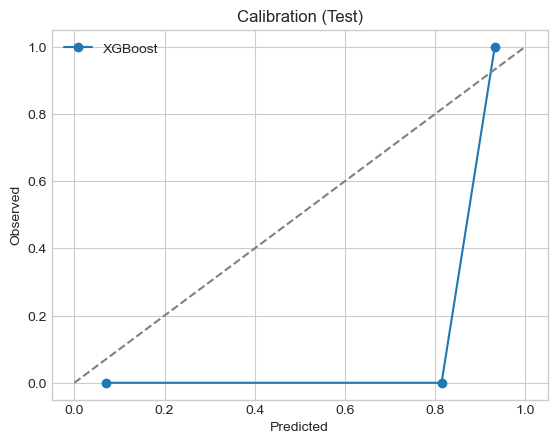

,feature,imp_mean,imp_std
79,total_agency_aid_pctchg_1,0.321717,0.05965
1,constant_dollar_amount,0.000000,0.00000
2,transaction_count_fiscal,0.000000,0.00000
3,mean_aid_per_transaction_fiscal,0.000000,0.00000
4,aid_volatility,0.000000,0.00000
5,rolling_mean_3yr,0.000000,0.00000
6,rolling_std_3yr,0.000000,0.00000
7,avg_agency_aid,0.000000,0.00000
8,aid_concentration_index,0.000000,0.00000
9,top3_agency_share,0.000000,0.00000


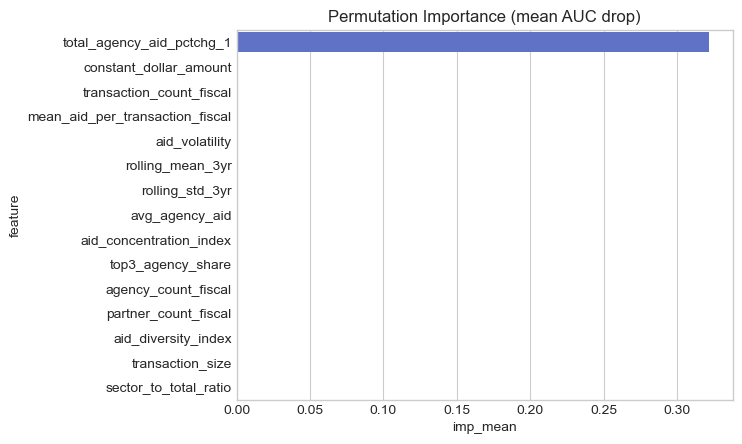


LIME explanation for test sample idx 6 (pred prob=0.939):


[('total_agency_aid_pctchg_1 <= -0.06', 0.573402397352354),
 ('top3_agency_share_lag3 > 0.11', -0.033763487457055666),
 ('sector_to_total_ratio_lag2 > -0.18', 0.028755192586850435),
 ('transaction_count_fiscal_lag1 > -0.17', 0.02725438653384212),
 ('total_aid_fiscal_lag2 > -0.19', 0.025809847378227672),
 ('total_aid_fiscal_lag3 > -0.19', 0.023594308790514412),
 ('avg_agency_aid_lag2 <= -0.42', -0.023392937291425706),
 ('current_dollar_amount_lag1 <= -0.44', -0.02268840000046826),
 ('constant_dollar_amount_lag1 <= -0.44', 0.02253646453212648),
 ('aid_concentration_index_lag3 <= -0.53', -0.01786153667237365)]

In [ ]:
# ===========================
# Refactored Agency-level Aid Cut Pipeline (Stable)
# ===========================


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, roc_auc_score, f1_score, auc,
    precision_recall_curve, confusion_matrix, accuracy_score,
    precision_score, recall_score
)
from sklearn.calibration import calibration_curve
import xgboost as xgb
import lime.lime_tabular

# ------------------------------------
# Setup
# ------------------------------------
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")
logger = logging.getLogger(__name__)

# ------------------------------------
# 0. Data Preparation
# ------------------------------------
df['fiscal_year'] = df['fiscal_year'].astype(int)

numeric_candidates = [
    'current_dollar_amount','constant_dollar_amount','transaction_count_fiscal',
    'mean_aid_per_transaction_fiscal','aid_volatility','rolling_mean_3yr',
    'rolling_std_3yr','total_agency_aid','avg_agency_aid','aid_concentration_index',
    'top3_agency_share','agency_count_fiscal','partner_count_fiscal','aid_diversity_index',
    'transaction_size','sector_to_total_ratio','agency_to_total_ratio',
    'aid_per_transaction_ratio','relative_aid_share','total_aid_fiscal'
]
for c in numeric_candidates:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

group_col = 'managing_subagency_or_bureau_name'
if group_col not in df.columns:
    raise RuntimeError(f"{group_col} not in dataframe columns")

# ------------------------------------
# 1. Aggregation
# ------------------------------------
agg_numeric = [c for c in numeric_candidates if c in df.columns and pd.api.types.is_numeric_dtype(df[c])]
agg_dict = {col: ('sum' if any(k in col for k in ['total','count','transaction']) else 'mean') for col in agg_numeric}
panel = df.groupby([group_col, 'fiscal_year'], as_index=False).agg(agg_dict).sort_values([group_col, 'fiscal_year']).reset_index(drop=True)

# ------------------------------------
# 2. Lag features + pct change
# ------------------------------------
for lag in [1, 2, 3]:
    for f in agg_numeric:
        panel[f'{f}_lag{lag}'] = panel.groupby(group_col)[f].shift(lag)

if 'total_agency_aid' in panel.columns:
    panel['total_agency_aid_pctchg_1'] = (panel['total_agency_aid'] - panel['total_agency_aid_lag1']) / panel['total_agency_aid_lag1'].replace(0, np.nan)
    panel['total_agency_aid_pctchg_2'] = (panel['total_agency_aid_lag1'] - panel['total_agency_aid_lag2']) / panel['total_agency_aid_lag2'].replace(0, np.nan)

# ------------------------------------
# 3. Target creation
# ------------------------------------
panel['aid_cut_flag'] = (panel['total_agency_aid'] < panel['total_agency_aid_lag1']).astype(int)
panel = panel[~panel['total_agency_aid_lag1'].isna()].reset_index(drop=True)

# ------------------------------------
# 4. Feature selection
# ------------------------------------
exclude = [group_col, 'fiscal_year', 'aid_cut_flag', 'total_agency_aid']
candidate_feats = [c for c in panel.columns if c not in exclude and pd.api.types.is_numeric_dtype(panel[c])]
logger.info(f"{len(candidate_feats)} numeric candidate features selected")

# ------------------------------------
# 5. Time-based split
# ------------------------------------
max_year = int(panel['fiscal_year'].max())
test_years = [max_year, max_year - 1]
val_years = [max_year - 2]
train_years = [y for y in sorted(panel['fiscal_year'].unique()) if y not in (test_years + val_years)]

train_df = panel[panel['fiscal_year'].isin(train_years)]
val_df = panel[panel['fiscal_year'].isin(val_years)]
test_df = panel[panel['fiscal_year'].isin(test_years)]

logger.info(f"Train years: {train_years}; Val: {val_years}; Test: {test_years}")
logger.info(f"Shapes — train: {train_df.shape}, val: {val_df.shape}, test: {test_df.shape}")

X_train, y_train = train_df[candidate_feats], train_df['aid_cut_flag']
X_val, y_val = val_df[candidate_feats], val_df['aid_cut_flag']
X_test, y_test = test_df[candidate_feats], test_df['aid_cut_flag']

# ------------------------------------
# 6. Impute + Scale
# ------------------------------------
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(imputer.fit_transform(X_train))
X_val_scaled = scaler.transform(imputer.transform(X_val))
X_test_scaled = scaler.transform(imputer.transform(X_test))

# ------------------------------------
# 7. XGBoost training
# ------------------------------------
pos, neg = int(y_train.sum()), int(len(y_train) - y_train.sum())
scale_pos_weight = (neg / (pos + 1e-9)) if pos > 0 else 1.0

dtrain, dval, dtest = [xgb.DMatrix(x, label=y) for x, y in [(X_train_scaled, y_train), (X_val_scaled, y_val), (X_test_scaled, y_test)]]

params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "eta": 0.05,
    "max_depth": 6,
    "min_child_weight": 5,
    "subsample": 0.8,
    "colsample_bytree": 0.7,
    "scale_pos_weight": scale_pos_weight,
    "seed": 42,
}

evallist = [(dtrain, 'train'), (dval, 'eval')]
bst = xgb.train(params, dtrain, num_boost_round=2000, evals=evallist,
                early_stopping_rounds=50, verbose_eval=50)

# ------------------------------------
# 8. Predictions + Threshold tuning
# ------------------------------------
best_iter = getattr(bst, "best_iteration", None)
pred_fn = lambda dm: bst.predict(dm, iteration_range=(0, best_iter)) if best_iter else bst.predict(dm)

y_val_prob, y_test_prob = pred_fn(dval), pred_fn(dtest)

best_thr, best_f1 = max(
    ((t, f1_score(y_val, (y_val_prob >= t).astype(int))) for t in np.linspace(0.01, 0.99, 99)),
    key=lambda x: x[1]
)
logger.info(f"Best threshold: {best_thr:.3f} (F1={best_f1:.3f})")

y_test_pred = (y_test_prob >= best_thr).astype(int)

# ------------------------------------
# 9. Evaluation
# ------------------------------------
print("\n=== Test Metrics ===")
print(f"AUC: {roc_auc_score(y_test, y_test_prob):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred, zero_division=0):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred, zero_division=0):.4f}")
print(f"F1: {f1_score(y_test, y_test_pred, zero_division=0):.4f}")
print("\nClassification report:\n", classification_report(y_test, y_test_pred, zero_division=0))

cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Test)')
plt.show()

precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_test_prob)
print("PR-AUC:", auc(recall_vals, precision_vals))

# Calibration plot
prob_true, prob_pred = calibration_curve(y_test, y_test_prob, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', label='XGBoost')
plt.plot([0,1],[0,1], linestyle='--', color='gray')
plt.xlabel('Predicted')
plt.ylabel('Observed')
plt.title('Calibration (Test)')
plt.legend()
plt.show()

# ------------------------------------
# 🔍 10. Manual Permutation Importance
# ------------------------------------
def compute_permutation_importance(predict_fn, X, y, features, n_repeats=30, random_state=42, metric=roc_auc_score):
    rng = np.random.default_rng(random_state)
    baseline = metric(y, predict_fn(xgb.DMatrix(X)))
    importances = []
    for i, feat in enumerate(features):
        scores = []
        for _ in range(n_repeats):
            X_perm = X.copy()
            idx = rng.permutation(len(X_perm))
            X_perm[:, i] = X_perm[idx, i]
            score = metric(y, predict_fn(xgb.DMatrix(X_perm)))
            scores.append(baseline - score)
        importances.append((feat, np.mean(scores), np.std(scores)))
    return pd.DataFrame(importances, columns=['feature','imp_mean','imp_std']).sort_values('imp_mean', ascending=False)

imp_df = compute_permutation_importance(pred_fn, X_test_scaled, y_test.values, candidate_feats)
display(imp_df.head(15))

sns.barplot(x='imp_mean', y='feature', data=imp_df.head(15), palette='coolwarm')
plt.title('Permutation Importance (mean AUC drop)')
plt.show()

# ------------------------------------
# 11. LIME Explainability
# ------------------------------------
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_scaled),
    feature_names=candidate_feats,
    class_names=['No Cut','Cut'],
    mode='classification'
)

i = np.random.randint(0, X_test_scaled.shape[0])
row = X_test_scaled[i]
pred_prob = pred_fn(xgb.DMatrix(row.reshape(1, -1)))[0]
exp = explainer.explain_instance(
    data_row=row,
    predict_fn=lambda x: np.vstack([1 - pred_fn(xgb.DMatrix(x)), pred_fn(xgb.DMatrix(x))]).T,
    num_features=min(10, len(candidate_feats))
)
print(f"\nLIME explanation for test sample idx {i} (pred prob={pred_prob:.3f}):")
display(exp.as_list())
exp.save_to_file(f"lime_agency_cut_explanation_{i}.html")


In [ ]:
# ---------------------------
# 13. Save artifacts
# ---------------------------
artifact = {
    "xgb_booster": bst,
    "imputer": imputer,
    "scaler": scaler,
    "features": candidate_feats,
    "threshold": best_thr
}
joblib.dump(artifact, "agency_cut_model_artifact.joblib")
logger.info("Saved model artifact to agency_cut_model_artifact.joblib")

# ---------------------------
# 14. Inference helper
# ---------------------------
def predict_aid_cuts(df_rows, artifact_path="agency_cut_model_artifact.joblib"):
    art = joblib.load(artifact_path)
    X_in = df_rows[art['features']].copy()
    X_imp = art['imputer'].transform(X_in)
    X_scaled = art['scaler'].transform(X_imp)
    dmat = xgb.DMatrix(X_scaled)
    best_iter_local = getattr(art['xgb_booster'], 'best_iteration', None)
    if best_iter_local is not None:
        probs = art['xgb_booster'].predict(dmat, iteration_range=(0, best_iter_local))
    else:
        probs = art['xgb_booster'].predict(dmat)
    preds = (probs >= art['threshold']).astype(int)
    return probs, preds

# Example usage
probs, preds = predict_aid_cuts(test_df.head())
print("\nSample predictions:")
print(pd.DataFrame({'prob_cut': probs, 'pred_cut': preds}))

,total_aid_fiscal
fiscal_year,
2010,5.085981e+12
2011,7.757711e+12
2012,8.530928e+12
2013,1.063417e+13
2014,9.717861e+12


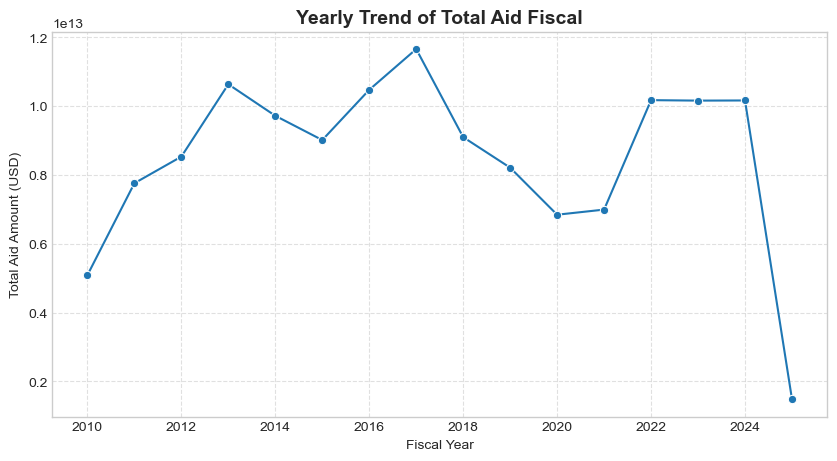

In [18]:
# ------- [Predictive Forecasting Preparation - Fixed] -------

# Define date and target columns
date_col = 'transaction_date'
target_col = 'total_aid_fiscal'  # try 'current_dollar_amount' or 'constant_dollar_amount' as well

# Aggregate data by fiscal year (or month if more granular)
time_series = (
    df.groupby('fiscal_year')[target_col]
      .sum()
      .reset_index()
      .sort_values('fiscal_year')
)

# Set fiscal_year as index
time_series = time_series.set_index('fiscal_year')

# Display sample
display(time_series.head())

# Plot baseline trend
plt.figure(figsize=(10, 5))
sns.lineplot(x=time_series.index, y=target_col, data=time_series, marker='o')
plt.title(f"Yearly Trend of {target_col.replace('_', ' ').title()}", fontsize=14, weight='bold')
plt.xlabel("Fiscal Year")
plt.ylabel("Total Aid Amount (USD)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

c:\Users\lenovo\anaconda3\envs\ds-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\lenovo\anaconda3\envs\ds-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\lenovo\anaconda3\envs\ds-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\lenovo\anaconda3\envs\ds-env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: 

ARIMA Forecast Performance (Total Aid Fiscal)
MAE:  3,447,374,321,651.35
RMSE: 5,337,969,594,869.29


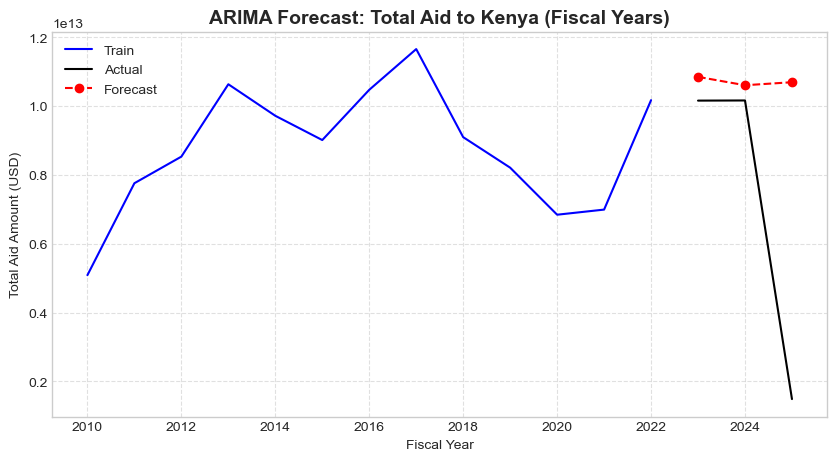

In [4]:
# ------- [Baseline ARIMA Forecast - Total Aid Fiscal] -------

# Extract target time series
ts = time_series['total_aid_fiscal']

# Split into train and test (last 3 fiscal years for testing)
train = ts.iloc[:-3]
test = ts.iloc[-3:]

# Fit ARIMA model (baseline)
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

# Forecast for test period
forecast = model_fit.forecast(steps=len(test))

# Evaluate model
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))

print("ARIMA Forecast Performance (Total Aid Fiscal)")
print(f"MAE:  {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")

# Plot actual vs forecast
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Train', color='blue')
plt.plot(test.index, test, label='Actual', color='black')
plt.plot(test.index, forecast, label='Forecast', color='red', linestyle='--', marker='o')
plt.title("ARIMA Forecast: Total Aid to Kenya (Fiscal Years)", fontsize=14, weight='bold')
plt.xlabel("Fiscal Year")
plt.ylabel("Total Aid Amount (USD)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

11:20:31 - cmdstanpy - INFO - Chain [1] start processing
11:20:32 - cmdstanpy - INFO - Chain [1] done processing


Prophet Forecast Performance (Total Aid Fiscal)
MAE:  3,776,568,081,080.20
RMSE: 4,475,886,959,496.08


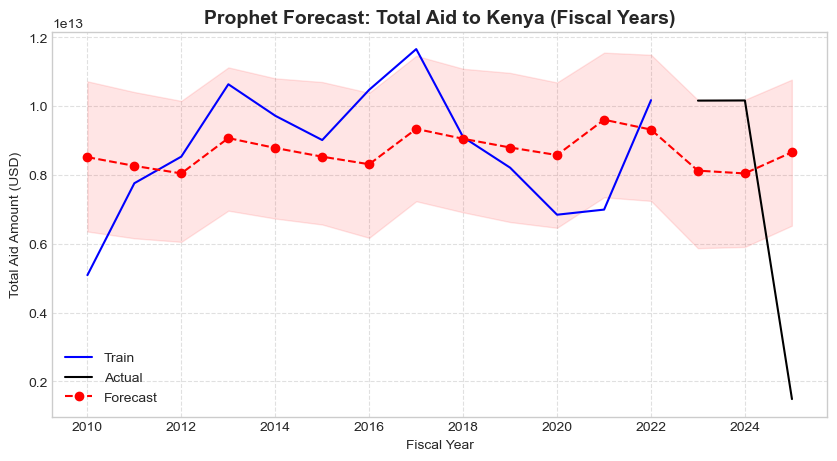

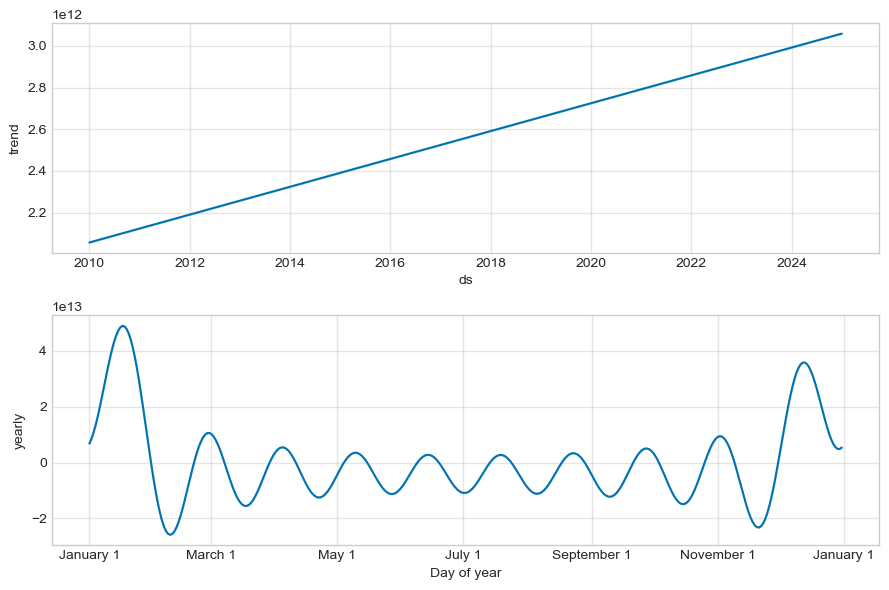

In [5]:
# ------- [Prophet Forecast - Total Aid Fiscal] -------

# Prepare data for Prophet
prophet_df = time_series.reset_index().rename(columns={'fiscal_year': 'ds', 'total_aid_fiscal': 'y'})
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'], format='%Y')

# Split into train and test (last 3 fiscal years)
train = prophet_df.iloc[:-3]
test = prophet_df.iloc[-3:]

# Initialize and fit Prophet model
model = Prophet(
    yearly_seasonality=True,
    seasonality_mode='additive'
)
model.fit(train)

# Create future dataframe by extending 3 years beyond test
future = model.make_future_dataframe(periods=3, freq='Y')
forecast = model.predict(future)

# Evaluate forecast by aligning dates
forecast_df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
eval_df = pd.merge_asof(
    test.sort_values('ds'),
    forecast_df.sort_values('ds'),
    on='ds',
    direction='nearest'
)

mae = mean_absolute_error(eval_df['y'], eval_df['yhat'])
rmse = np.sqrt(mean_squared_error(eval_df['y'], eval_df['yhat']))

print("Prophet Forecast Performance (Total Aid Fiscal)")
print(f"MAE:  {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")

# Plot forecast
plt.figure(figsize=(10, 5))
plt.plot(train['ds'], train['y'], label='Train', color='blue')
plt.plot(test['ds'], test['y'], label='Actual', color='black')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='red', linestyle='--', marker='o')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='red', alpha=0.1)
plt.title("Prophet Forecast: Total Aid to Kenya (Fiscal Years)", fontsize=14, weight='bold')
plt.xlabel("Fiscal Year")
plt.ylabel("Total Aid Amount (USD)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 7Trend and seasonality decomposition
model.plot_components(forecast)
plt.show()